In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from batch_train_smart import get_hidden_dim_max

# Current width analysis

In [35]:
filename="../results_relu.xlsx"
hidden_layers = 1

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.rcParams['figure.dpi'] = 140

In [36]:
data = pd.read_excel(filename)
data = data[data["hidden-layers"] == hidden_layers]

In [37]:
groupby_cols = [
    'd', 'M', 'T', 'act', 'noise', 'hidden-layers',
    'patience', 'patience-tol', 'epochs', 
    'lr', 'reduce-lr',
]
data_groupby = data.groupby(groupby_cols).agg( 
    width_median=pd.NamedAgg(column="model", aggfunc="median"),
    width_75=("model", lambda x: x.quantile(0.75)),
).reset_index()
data_groupby["width_limit"] = get_hidden_dim_max(
    hidden_layers, 
    data_groupby["M"], 
    data_groupby["d"], 
    data_groupby["T"],
)

In [38]:
def format_ax(ax):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

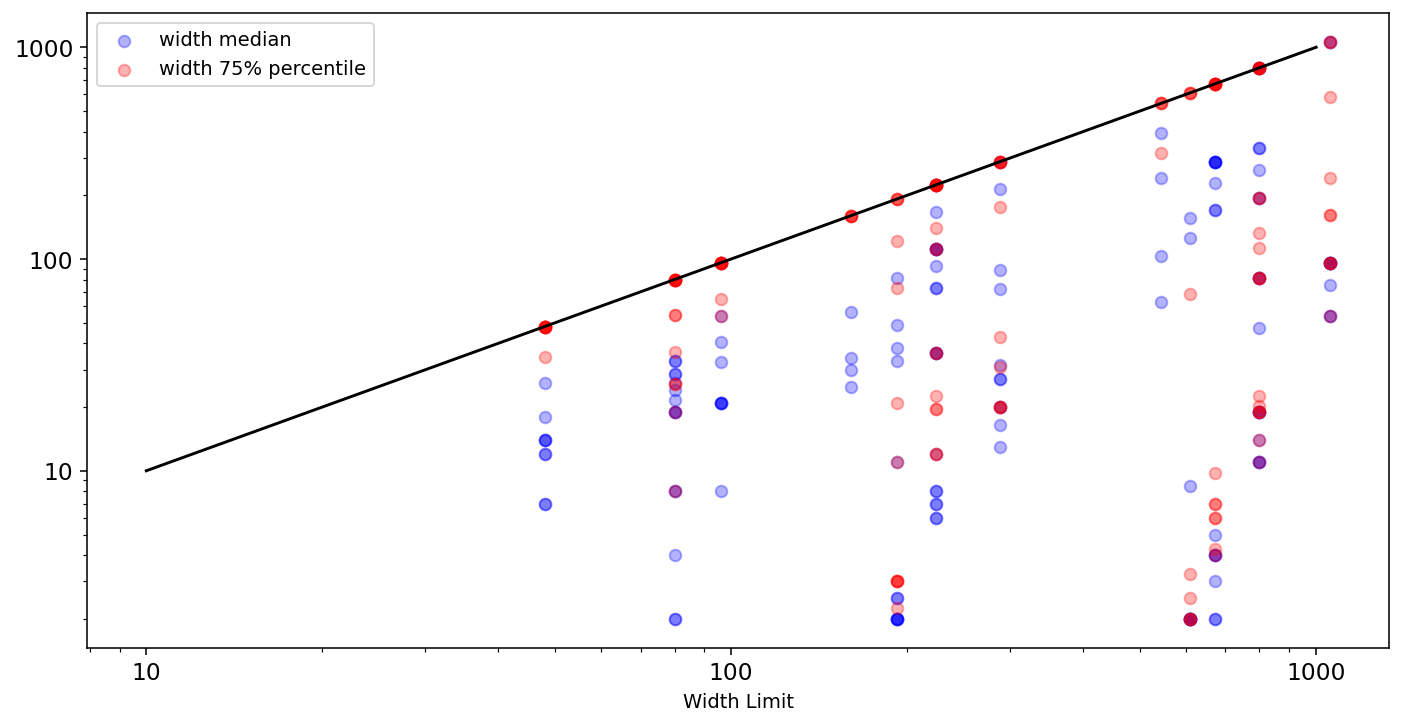

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter( 
    data_groupby["width_limit"],
    data_groupby["width_median"],
    alpha=0.3,
    color='blue',
)
ax.scatter( 
    data_groupby["width_limit"],
    data_groupby["width_75"],
    alpha=0.3,
    color='red',
)
format_ax(ax)
ax.plot( 
    [1e1, 1e3],
    [1e1, 1e3],
    color='black',
)
# ax.set_aspect('equal')
ax.set_xlabel("Width Limit")
ax.legend(["width median", "width 75% percentile"])
plt.show()

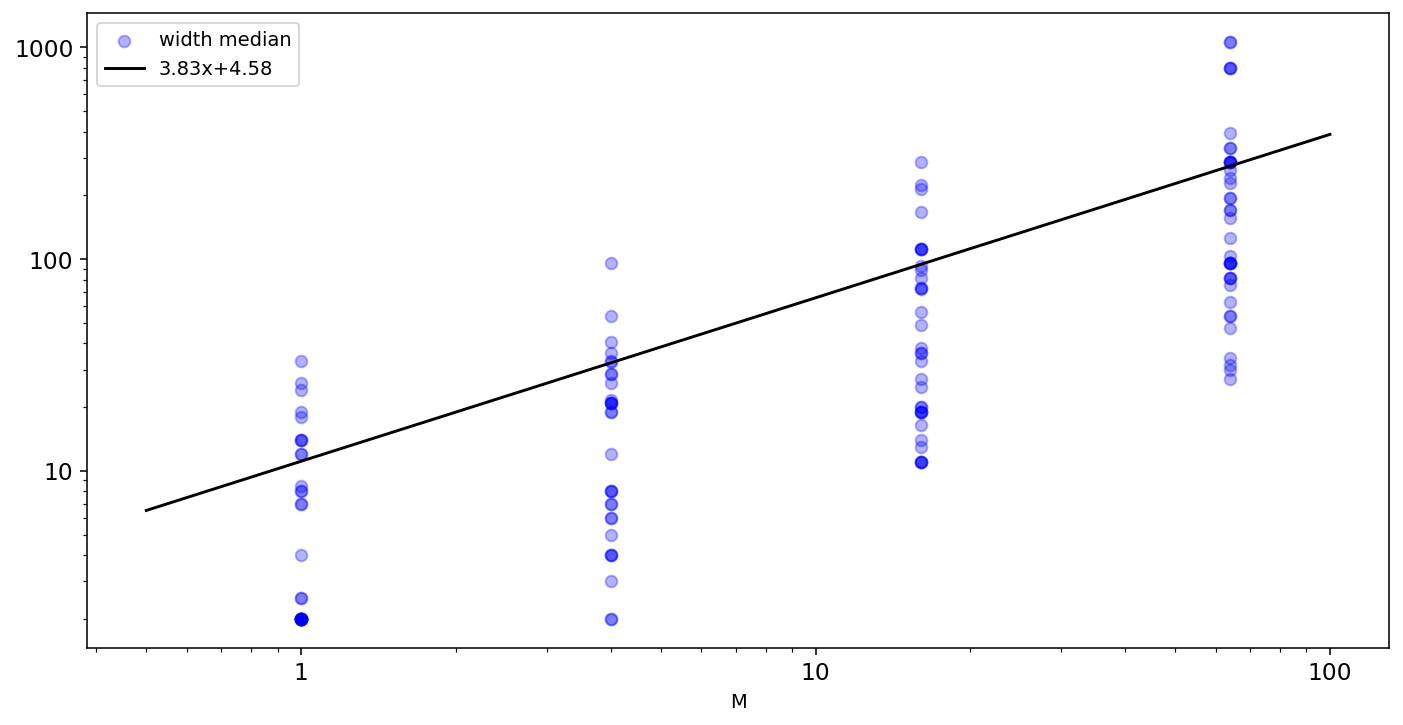

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter( 
    data_groupby["M"],
    data_groupby["width_median"],
    alpha=0.3,
    color='blue',
)
z = np.polyfit(data_groupby["M"], data_groupby["width_median"], deg=1)
p = np.poly1d(z)
limits = [0.5, 100]
ax.plot( 
    limits,
    [p(x) for x in limits],
    color='black',
)
ax.legend([ 
    'width median',
    f"{z[0]:.2f}x+{z[1]:.2f}"
])
format_ax(ax)
ax.set_xlabel("M")
plt.show()

# Fixed width vs width tuning

In [41]:
def flatten(df):
    names = df.columns.names
    values = df.columns.values
    cols = []
    m = len(names)
    n = len(values)
    for i in range(n):
        s = ''
        for j in range(m):
            if names[j] and str(values[i][j]):
                s += str(names[j]) + '-'
            if str(values[i][j]):
                s += str(values[i][j]) + '-'
        cols.append(s[:-1])
    df.columns = cols
    return df

def geometric_mean(x):
    return np.exp(np.mean(np.log(x)))

def to_exp_str(l):
    return [f"$2^{{{np.log2(x)}}}$" for x in l]

def format_ax(ax):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

In [59]:
same_width_df = pd.read_excel("../analysis_relu_width_same_0.98.xlsx")
fixed_width_df = pd.read_excel("../analysis_relu_width_4M_4_0.98.xlsx")
best_width_df = pd.read_excel("../analysis_relu_width_best_0.98.xlsx")
width_tuning_df = pd.read_excel("../analysis_relu0.98.xlsx")

width_tuning_df = width_tuning_df[width_tuning_df["hidden-layers"] == 1]

fixed_width_df = pd.pivot( 
    fixed_width_df,
    index=['d', 'M', 'T', 'act', 'noise'],
    columns=['trials'],
    values=['epsilon'],
).reset_index()
fixed_width_df = flatten(fixed_width_df)

best_width_df = pd.pivot( 
    best_width_df,
    index=['d', 'M', 'T', 'act', 'noise'],
    columns=['trials'],
    values=['epsilon'],
).reset_index()
best_width_df = flatten(best_width_df)

same_width_df = pd.pivot( 
    same_width_df,
    index=['d', 'M', 'T', 'act', 'noise'],
    columns=['trials'],
    values=['epsilon'],
).reset_index()
same_width_df = flatten(same_width_df)

In [62]:
cols = ["d", "M", "T", "act", "noise", "epsilon"]
analysis = fixed_width_df.merge(
    best_width_df,
    on=["d", "M", "T", "act", "noise"],
    suffixes=['-fixed', '-best'],
    how='outer',
).merge(
    same_width_df,
    on=["d", "M", "T", "act", "noise"],
    how='outer',
).merge( 
    width_tuning_df[cols],
    on=["d", "M", "T", "act", "noise"],
    how='outer',
)
analysis["epsilon_ratio_fixed_tune"] = analysis["epsilon-trials-1-fixed"] / analysis["epsilon"]
analysis["epsilon_ratio_fixed_8_tune"] = analysis["epsilon-trials-8-fixed"] / analysis["epsilon"]
analysis["epsilon_ratio_best_tune"] = analysis["epsilon-trials-1-best"] / analysis["epsilon"]
analysis["epsilon_ratio_best_8_tune"] = analysis["epsilon-trials-8-best"] / analysis["epsilon"]
analysis["epsilon_ratio_same_tune"] = analysis["epsilon-trials-1"] / analysis["epsilon"]
analysis["epsilon_ratio_same_8_tune"] = analysis["epsilon-trials-8"] / analysis["epsilon"]

col_names = [
    "epsilon_ratio_fixed_tune",
    "epsilon_ratio_fixed_8_tune",
    "epsilon_ratio_best_tune",
    "epsilon_ratio_best_8_tune",
    "epsilon_ratio_same_tune",
    "epsilon_ratio_same_8_tune",
]
col_descriptions = [
    '$\\epsilon_{fixed}/\\epsilon_{tune}$', 
    '$\\epsilon_{fixed, 8}/\\epsilon_{tune}$',
    '$\\epsilon_{best}/\\epsilon_{tune}$', 
    '$\\epsilon_{best, 8}/\\epsilon_{tune}$', 
    '$\\epsilon_{same}/\\epsilon_{tune}$', 
    '$\\epsilon_{same, 8}/\\epsilon_{tune}$', 
]

analysis

,d,M,T,act,noise,epsilon-trials-1-fixed,epsilon-trials-8-fixed,epsilon-trials-1-best,epsilon-trials-8-best,epsilon-trials-1,epsilon-trials-8,epsilon,epsilon_ratio_fixed_tune,epsilon_ratio_fixed_8_tune,epsilon_ratio_best_tune,epsilon_ratio_best_8_tune,epsilon_ratio_same_tune,epsilon_ratio_same_8_tune
0,1,1,8,relu,0.1,0.202923,0.131362,0.168792,0.113004,0.305020,0.349865,0.154869,1.310289,0.848210,1.089903,0.729676,1.969530,2.259097
1,1,1,8,relu,0.2,0.154011,0.131376,0.184268,0.180248,0.282534,0.371999,0.159200,0.967404,0.825225,1.157460,1.132209,1.774709,2.336675
2,1,1,16,relu,0.1,0.034767,0.030222,0.113973,0.060324,0.213560,0.034101,0.053632,0.648253,0.563503,2.125105,1.124774,3.981971,0.635842
3,1,1,16,relu,0.2,0.105370,0.133295,0.078518,0.081952,0.214659,0.083387,0.071998,1.463503,1.851370,1.090550,1.138256,2.981448,1.158187
4,1,1,32,relu,0.1,0.012689,0.016118,0.043963,0.015026,0.087292,0.026858,0.016285,0.779212,0.989731,2.699641,0.922665,5.360280,1.649276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,64,64,65536,relu,0.1,0.010539,0.010070,0.005865,0.004963,0.006071,NaN,0.005860,1.798608,1.718507,1.000917,0.847000,1.036053,NaN
133,64,64,65536,relu,0.2,0.026664,0.024586,0.020676,0.018123,0.019060,NaN,0.019652,1.356764,1.251062,1.052101,0.922194,0.969867,NaN
134,64,64,131072,relu,0.1,0.004161,0.003898,0.003438,0.002342,0.003065,NaN,0.002803,1.484460,1.390643,1.226416,0.835544,1.093609,NaN
135,64,64,131072,relu,0.2,0.013700,0.012806,0.011275,0.009262,0.010099,NaN,0.010263,1.334886,1.247726,1.098571,0.902492,0.984014,NaN


In [63]:
for col, col_d in zip(col_names, col_descriptions):
    print(f"{col_d}:{geometric_mean(analysis[col])}")

$\epsilon_{fixed}/\epsilon_{tune}$:1.3145250331659581
$\epsilon_{fixed, 8}/\epsilon_{tune}$:1.2050579779534152
$\epsilon_{best}/\epsilon_{tune}$:1.235575707620733
$\epsilon_{best, 8}/\epsilon_{tune}$:0.9337845170156848
$\epsilon_{same}/\epsilon_{tune}$:1.6873918031158077
$\epsilon_{same, 8}/\epsilon_{tune}$:0.8428656901787748


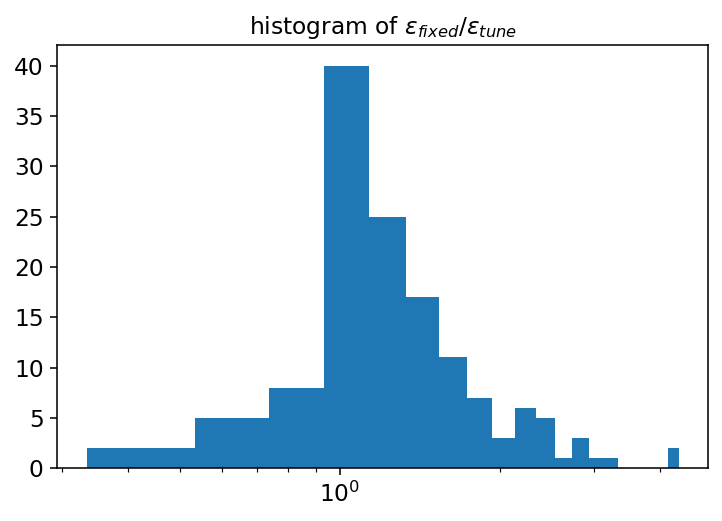

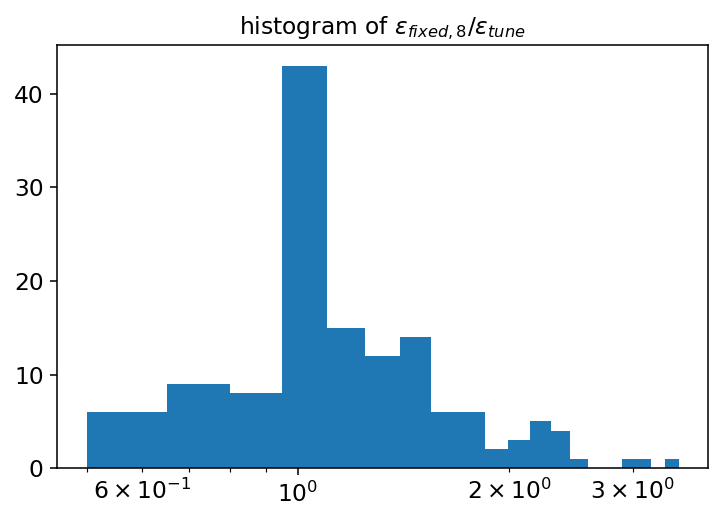

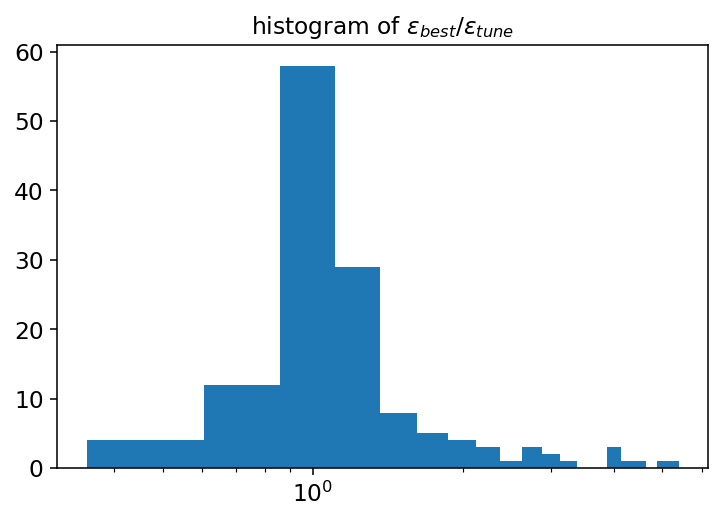

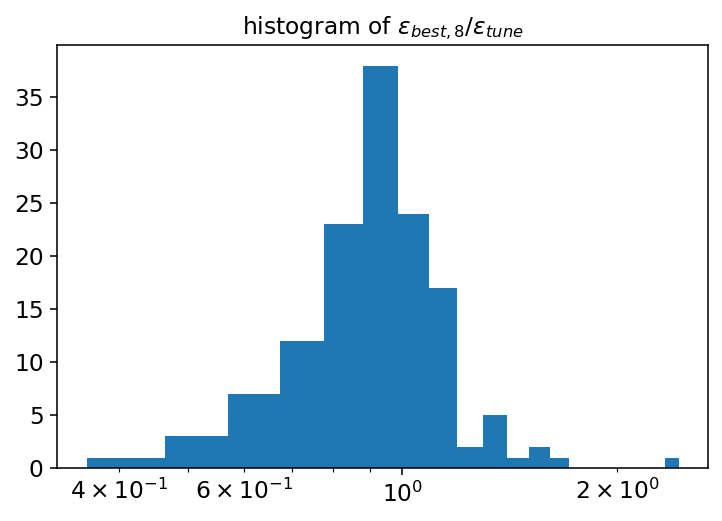

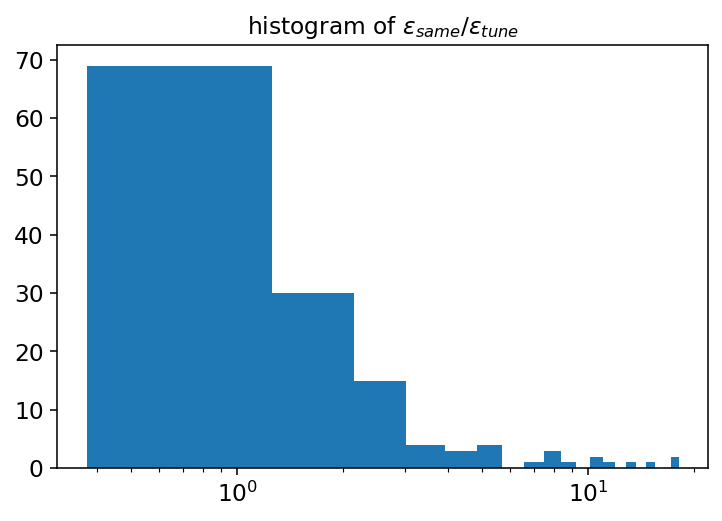

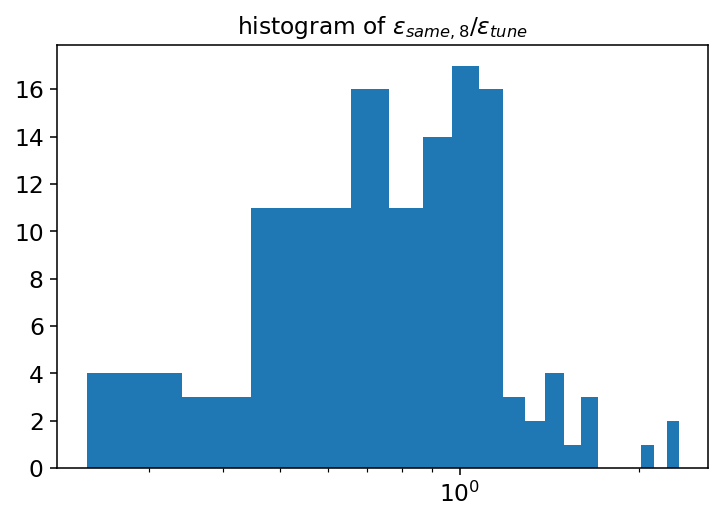

In [64]:
for col, col_d in zip(col_names, col_descriptions):
    plt.hist( 
        analysis[col],
        bins=20,
    )
    plt.xscale('log')
    plt.title(f"histogram of {col_d}")
    plt.show()

In [65]:
def scatter_plot(ax, data, x_col, y_cols, x_label, y_labels, reference=None):
    legends = []
    if reference is not None:
        ax.hlines( 
            reference, 
            data[x_col].min(), 
            data[x_col].max(),
            colors='black',
        )
        legends.append('reference')
    colors = plt.cm.viridis(np.linspace(0, 1, len(y_cols)))
    for y_col, y_label, c in zip(y_cols, y_labels, colors):
        # ax.scatter( 
        #     x = data[x_col],
        #     y = data[y_col],
        #     alpha = 0.3,
        #     color=c,
        # )
        # legends.append(f"{y_label} scatter")
        temp = data.groupby(x_col).agg({
            y_col: geometric_mean
        }).reset_index()
        ax.plot( 
            temp[x_col], 
            temp[y_col],
            color=c,
        )
        legends.append(f"{y_label} geometric mean")
    format_ax(ax)
    ax.set_xticks(data[x_col])
    ax.set_xticklabels(to_exp_str(data[x_col]))
    ax.set_xlabel(x_label)
    ax.legend(legends)
    return ax

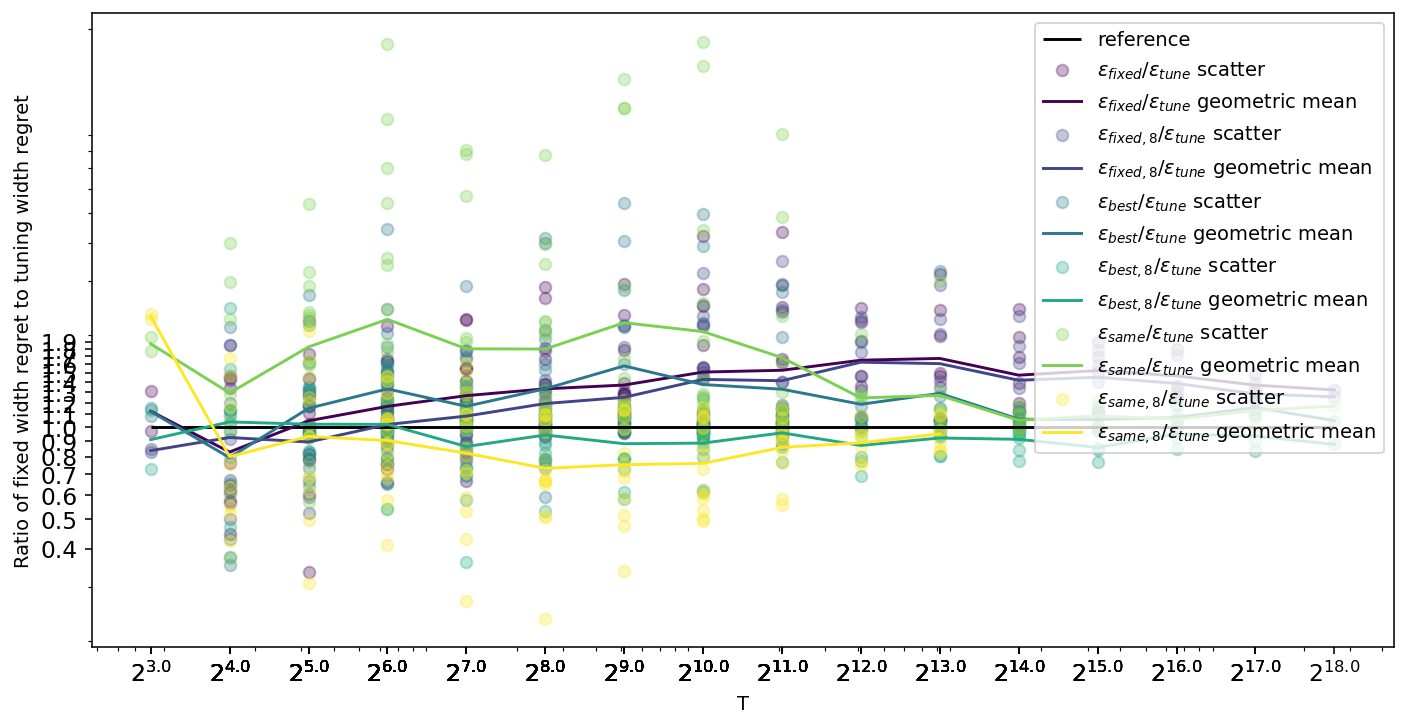

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = scatter_plot(
    ax,
    analysis, 
    "T",
    col_names,
    "T",
    col_descriptions,
    reference=1,
)
ax.set_ylabel("Ratio of fixed width regret to tuning width regret")
ax.set_yticks(np.arange(0.4, 2, 0.1))
plt.show()

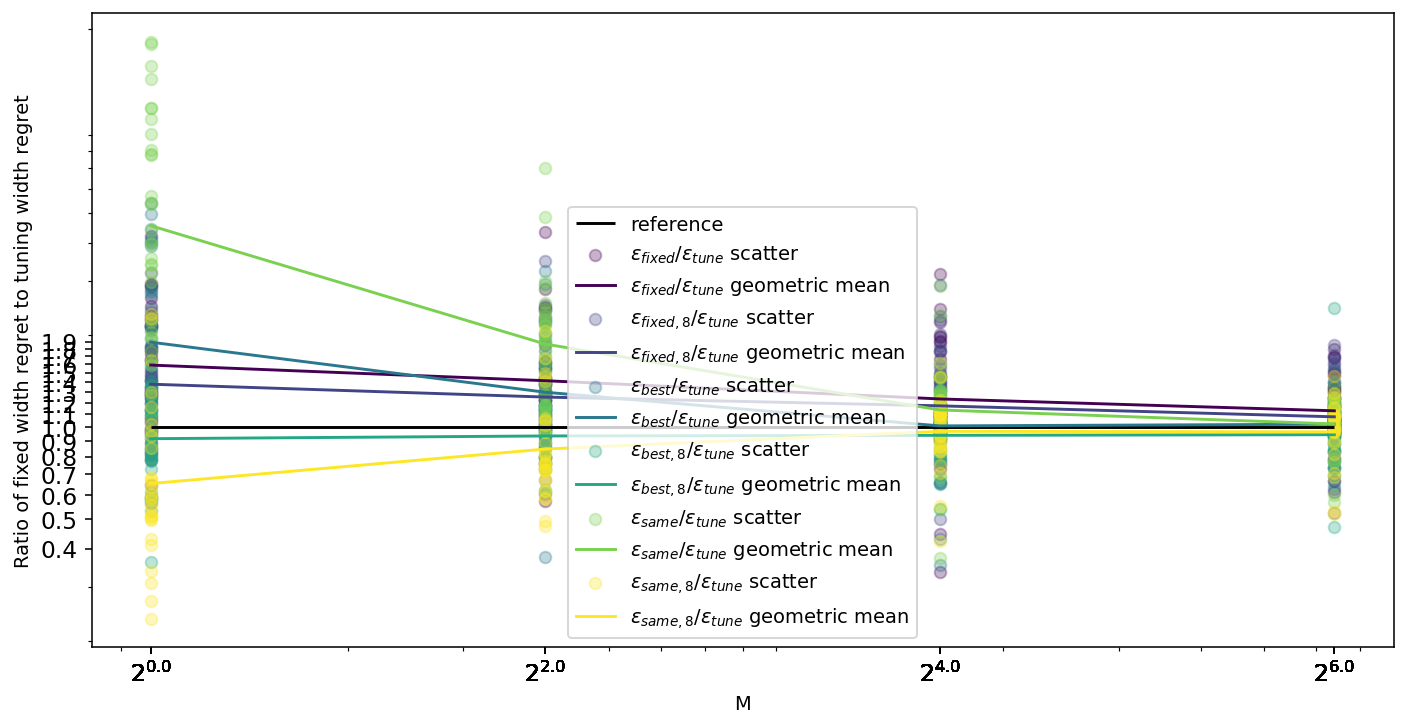

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = scatter_plot(
    ax,
    analysis, 
    "M",
    col_names,
    "M",
    col_descriptions,
    reference=1,
)
ax.set_ylabel("Ratio of fixed width regret to tuning width regret")
ax.set_yticks(np.arange(0.4, 2, 0.1))
plt.show()

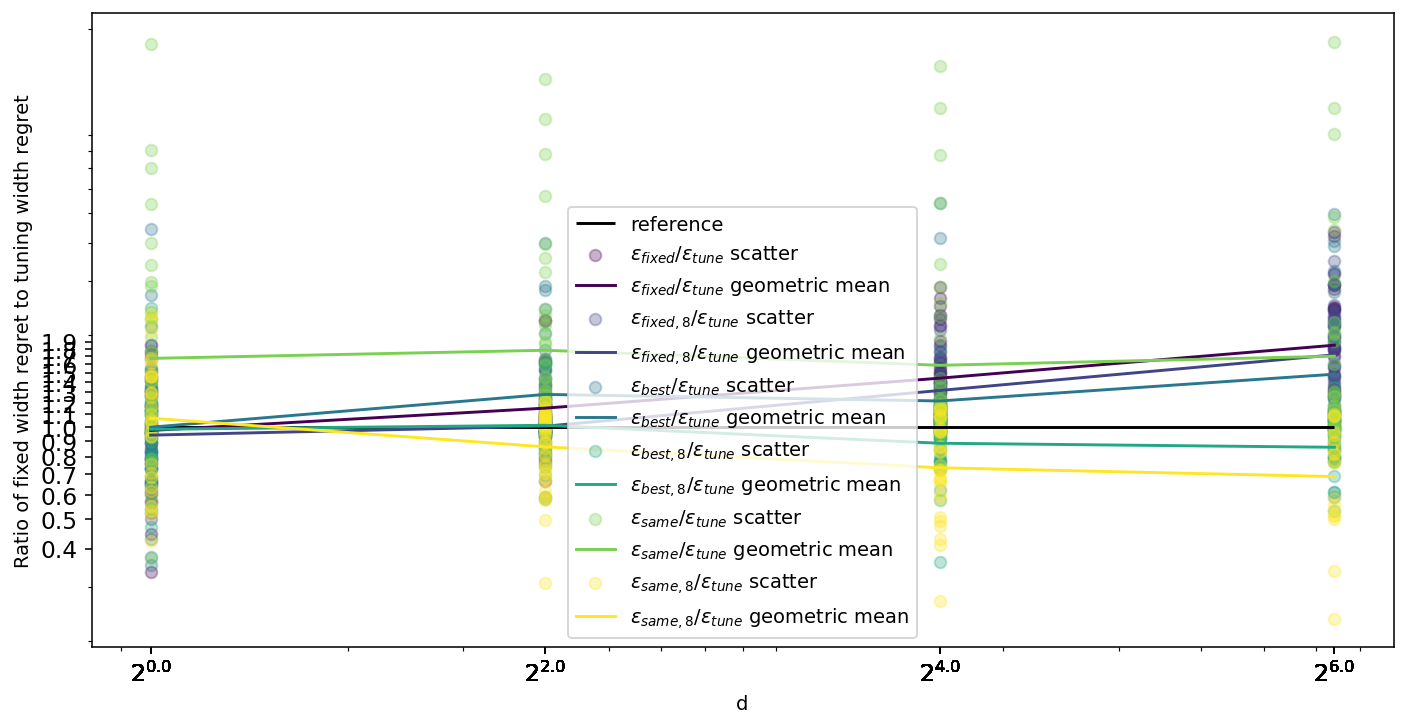

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = scatter_plot(
    ax,
    analysis, 
    "d",
    col_names,
    "d",
    col_descriptions,
    reference=1,
)
ax.set_ylabel("Ratio of fixed width regret to tuning width regret")
ax.set_yticks(np.arange(0.4, 2, 0.1))
plt.show()

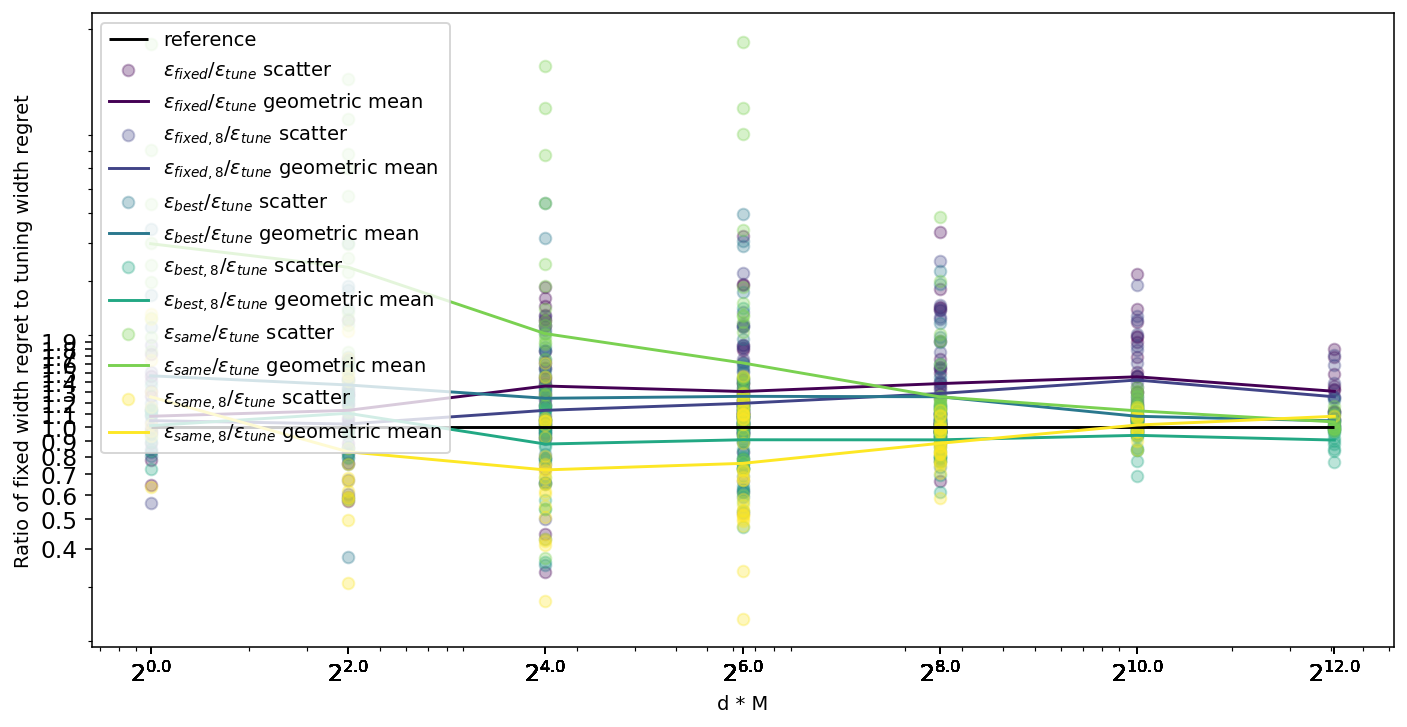

In [69]:
temp = analysis.copy()
temp["dM"] = temp["d"] * temp["M"]
fig, ax = plt.subplots(figsize=(12, 6))
ax = scatter_plot(
    ax,
    temp, 
    "dM",
    col_names,
    "d * M",
    col_descriptions,
    reference=1,
)
ax.set_ylabel("Ratio of fixed width regret to tuning width regret")
ax.set_yticks(np.arange(0.4, 2, 0.1))
plt.show()

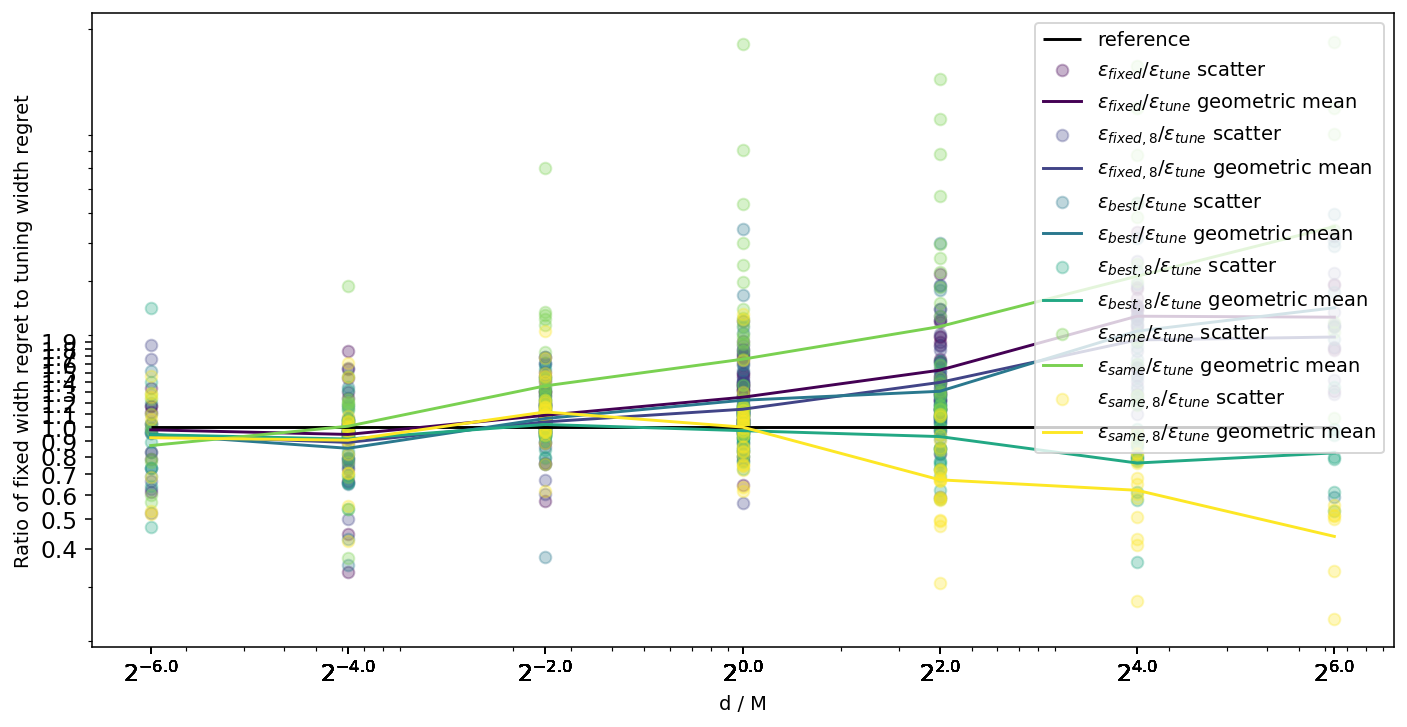

In [70]:
temp = analysis.copy()
temp["dM"] = temp["d"] / temp["M"]
fig, ax = plt.subplots(figsize=(12, 6))
ax = scatter_plot(
    ax,
    temp, 
    "dM",
    col_names,
    "d / M",
    col_descriptions,
    reference=1,
)
ax.set_ylabel("Ratio of fixed width regret to tuning width regret")
ax.set_yticks(np.arange(0.4, 2, 0.1))
plt.show()

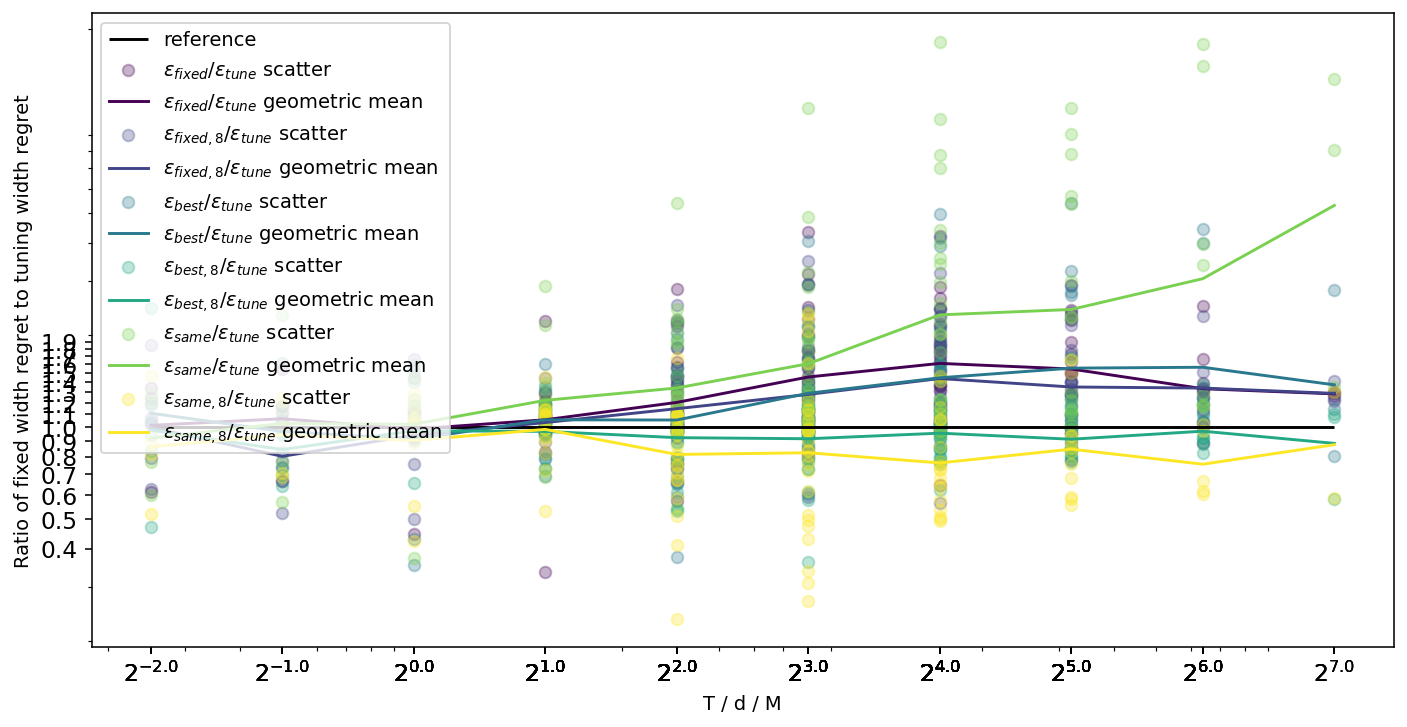

In [71]:
temp = analysis.copy()
temp["dMT"] = temp["T"] / temp["M"] / temp["d"]
fig, ax = plt.subplots(figsize=(12, 6))
ax = scatter_plot(
    ax,
    temp, 
    "dMT",
    col_names,
    "T / d / M",
    col_descriptions,
    reference=1,
)
ax.set_ylabel("Ratio of fixed width regret to tuning width regret")
ax.set_yticks(np.arange(0.4, 2, 0.1))
plt.show()

# Config generation

In [53]:
filename="../analysis_relu0.98.xlsx"
current = pd.read_excel(filename)

In [54]:
def add_cols(data):
    data['T'] = data['T'].astype('int')
    data['act'] = "relu"
    data['patience'] = 40
    data['patience-tol'] = 0.01
    data['batch-size'] = 64
    data['epochs'] = 1500
    data['weight-decay'] = 0
    data['lr'] = 0.000
    data['dropout'] = 0
    data = data.drop_duplicates()
    data['count'] = 1
    data['comment'] = 'reduce-lr'
    data['reduce-lr'] = 'T'
    return data

In [55]:
current = current[current["hidden-layers"] == 1]
current = add_cols(current[["d", "M", "T", "noise", "hidden-layers"]].copy())

In [56]:
current["model"] = current["M"]
current["count"] = 2
current["trials"] = 8

In [57]:
current.sort_values('T')#.to_csv('config.tsv', sep='\t', index=False)

,d,M,T,noise,hidden-layers,act,patience,patience-tol,batch-size,epochs,weight-decay,lr,dropout,count,comment,reduce-lr,model,trials
0,1,1,8,0.1,1,relu,40,0.01,64,1500,0,0.0,0,2,reduce-lr,T,1,8
402,1,1,8,0.2,1,relu,40,0.01,64,1500,0,0.0,0,2,reduce-lr,T,1,8
17,1,4,16,0.1,1,relu,40,0.01,64,1500,0,0.0,0,2,reduce-lr,T,4,8
422,1,4,16,0.2,1,relu,40,0.01,64,1500,0,0.0,0,2,reduce-lr,T,4,8
31,1,16,16,0.1,1,relu,40,0.01,64,1500,0,0.0,0,2,reduce-lr,T,16,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,64,64,65536,0.2,1,relu,40,0.01,64,1500,0,0.0,0,2,reduce-lr,T,64,8
719,16,64,131072,0.2,1,relu,40,0.01,64,1500,0,0.0,0,2,reduce-lr,T,64,8
828,64,64,131072,0.2,1,relu,40,0.01,64,1500,0,0.0,0,2,reduce-lr,T,64,8
362,64,64,131072,0.1,1,relu,40,0.01,64,1500,0,0.0,0,2,reduce-lr,T,64,8


In [58]:
to_run = data_groupby[
    ["d", "M", "T", "act", "noise", "width_median", "hidden-layers"]
].rename(columns={"width_median": "model"})
to_run = add_cols(to_run.copy())
to_run["model"] = to_run["model"].astype('int')
to_run["count"] = 8
to_run["trials"] = 8
to_run.sort_values('T')#.to_csv('config1.tsv', sep='\t', index=False)

,d,M,T,act,noise,model,hidden-layers,patience,patience-tol,batch-size,epochs,weight-decay,lr,dropout,count,comment,reduce-lr,trials
0,1,1,8,relu,0.1,14,1,40,0.01,64,1500,0,0.0,0,8,reduce-lr,T,8
1,1,1,8,relu,0.2,12,1,40,0.01,64,1500,0,0.0,0,8,reduce-lr,T,8
2,1,1,16,relu,0.1,18,1,40,0.01,64,1500,0,0.0,0,8,reduce-lr,T,8
3,1,1,16,relu,0.2,26,1,40,0.01,64,1500,0,0.0,0,8,reduce-lr,T,8
24,1,64,16,relu,0.2,30,1,40,0.01,64,1500,0,0.0,0,8,reduce-lr,T,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,64,64,65536,relu,0.2,75,1,40,0.01,64,1500,0,0.0,0,8,reduce-lr,T,8
104,16,64,131072,relu,0.2,194,1,40,0.01,64,1500,0,0.0,0,8,reduce-lr,T,8
134,64,64,131072,relu,0.1,96,1,40,0.01,64,1500,0,0.0,0,8,reduce-lr,T,8
135,64,64,131072,relu,0.2,96,1,40,0.01,64,1500,0,0.0,0,8,reduce-lr,T,8
